In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision
import datasets
from datasets import load_dataset

import nevergrad as ng

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm

from models import CNN_Simple,All_CNN_C,VAE,LSTM

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(device)

cuda:0


In [206]:
class TrainManager:
    def __init__(self,model,dataloader_train,dataloader_test,loss,device,isLSTM=False):
        self.device = device
        self.model = model.to(self.device)
        self.loss  = loss.to(device)
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.best_score = 1e9
        self.loss = loss
        self.epoch = 1
        self.batch_nb = 0
        self.max_batch = len(dataloader_train)
        self.iteration = 0
        self.output = []
        self.best_output = []
        self.LSTM = isLSTM
        

    def weights_updating(self,weights):
        for n, layer in enumerate(self.model.parameters().to(device)):
            layer.data = torch.from_numpy(weights[n]).to(device)
            
    def evaluate(self):
        if not self.LSTM:
            total_loss,total_correct,total_samples = 0,0,0
            for x , y in self.dataloader_test :
                x,y = x.to(device),y.to(device)
                yhat = self.model(x).to(device)
                loss = self.loss(yhat,y)
                total_loss += loss.item()
                predicted_classes = torch.argmax(yhat, dim=1).to(torch.int)
                total_correct += (predicted_classes == y.to(torch.int)).sum().item()
                total_samples += y.numel()
            total_loss /= len(self.dataloader_test)
            total_correct /= total_samples
        else:
            total_loss,total_correct,total_samples = 0,0,0
            for i, data in enumerate(self.dataloader_test):
                inputs = data.to(self.device)
                labels = inputs[:, 1:].to(self.device)
                outputs = self.model(inputs)
                outputs = outputs[:, :-1, :].permute(0, 2, 1)
                loss = self.loss(outputs, labels)
                total_loss += loss.item()
                if type(outputs) is tuple:
                    outputs = outputs[0]
                predicted = torch.argmax(outputs, dim=1)
                correct = torch.sum(predicted == labels).item()
                total_correct += correct
                total_samples += labels.numel()
        return total_loss,total_correct/total_samples

    def cost_function(self, parameters):
        self.batch_nb = self.iteration%self.max_batch

        load_params(self.model, torch.tensor(parameters))
        if not self.LSTM:
            x,y = list(self.dataloader_train)[self.batch_nb][0].to(device), list(self.dataloader_train)[self.batch_nb][1].to(device)
            predi = self.model(x).to(device)
            loss  = self.loss(predi,y).to(device)
        else:
            for i, data in enumerate(self.dataloader_train):
                if i==self.batch_nb:
                    inputs = data.to(self.device)
                    # learn to predict next token, label is next elem
                    labels = inputs[:,1:].to(self.device)
                    outputs = self.model(inputs).to(device)
                    outputs = outputs[:, :-1, :].permute(0, 2, 1)
                    loss = self.loss(outputs, labels)

        #if self.batch_nb == self.max_batch-1:   #evaluate test loss once per epoch
        test_loss,accuracy = self.evaluate()
        if self.best_score > test_loss :
            self.best_score = test_loss
            self.best_model = copy.deepcopy(self.model)
            
        self.output.append([test_loss,accuracy])
        self.best_output.append(self.best_score)
        print(f'epoch {self.epoch}, batch {self.batch_nb+1}; test loss function (cross entropy loss) : {test_loss}, accuracy {accuracy*100}, best score : {self.best_score}')
        self.iteration += 1
        if self.iteration%self.max_batch == 0: self.epoch += 1
        return loss.item()

In [62]:
class VAE_loss(torch.nn.Module):
    def __init__(self):
        super(VAE_loss, self).__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()
    def forward(self, preds, labels):
        x, mean, logvar = preds
        reproduction_loss = self.loss_fn(x, labels)
        return reproduction_loss

In [160]:
def load_params(model, param_tensor):
    current_index = 0
    for param in model.parameters():
        param_length = param.numel()
        #print(param_length, param.size())
        param.data = param_tensor[current_index:current_index + param_length].reshape(param.size()).to(device)
        current_index += param_length
    #model.flatten_parameters()

P1 : simple CNN for classification of Fashion MNIST

In [207]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])
training_set = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//10, shuffle=False)

In [208]:
model = CNN_Simple().to(device)
torch.save(model.state_dict(), 'models/CNN_Simple.pt')
loss = nn.CrossEntropyLoss()

restart here to test another optimizer

In [209]:
model.load_state_dict(torch.load('models/CNN_Simple.pt'))

epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model,training_loader,validation_loader,loss,device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch)

In [210]:
learned_param = optimizer.minimize(fitness)

epoch 1, batch 1; test loss function (cross entropy loss) : 2.3025850929940463, accuracy 0.001, best score : 2.3025850929940463
epoch 1, batch 2; test loss function (cross entropy loss) : 155155.8214666006, accuracy 0.001, best score : 2.3025850929940463
epoch 1, batch 3; test loss function (cross entropy loss) : 28797.42438546407, accuracy 0.000472, best score : 2.3025850929940463
epoch 1, batch 4; test loss function (cross entropy loss) : 11811.04104394409, accuracy 0.0008740000000000001, best score : 2.3025850929940463
epoch 1, batch 5; test loss function (cross entropy loss) : 5294.5287044576635, accuracy 0.0006270000000000001, best score : 2.3025850929940463
epoch 1, batch 6; test loss function (cross entropy loss) : 5582.587244461583, accuracy 0.001438, best score : 2.3025850929940463
epoch 1, batch 7; test loss function (cross entropy loss) : 1436.1513479758494, accuracy 0.001291, best score : 2.3025850929940463
epoch 1, batch 8; test loss function (cross entropy loss) : 1115.35

P2: VAE for generation on MNIST

In [77]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double())])
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

In [79]:
model = VAE().to(device)
torch.save(model.state_dict(), 'models/VAE.pt')

In [81]:
loss = VAE_loss()

restart here for different optimizer (NGOpt and SPSA)

In [91]:
model.load_state_dict(torch.load('models/VAE.pt'))

<All keys matched successfully>

In [84]:
epochs = 1
trainer = TrainManager(model,training_loader,validation_loader,loss)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs)

In [85]:
learned_param = optimizer.minimize(fitness)

epoch 1, batch 1; test loss function (cross entropy loss) : 6.6603685504075125, best score : 6.6603685504075125


P3: VAE for generation on MNIST (P2 on a different dataset)

In [86]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [88]:
model = VAE().to(device)
loss = VAE_loss()
torch.save(model.state_dict(), 'models/VAE.pt')

restart here for different optimizers

In [ ]:
model.load_state_dict(torch.load('models/VAE.pt'))

In [92]:
epochs = 1
trainer = TrainManager(model,training_loader,validation_loader,loss)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs)

In [93]:
learned_param = optimizer.minimize(fitness)

epoch 1, batch 1; test loss function (cross entropy loss) : 6.651875184703448, best score : 6.651875184703448


P4: All-CNNC-C for classification on CIFAR-100

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))]
)

training_set = torchvision.datasets.CIFAR100('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR100('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//1000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
model = All_CNN_C().to(device)
loss = torch.nn.CrossEntropyLoss()
torch.save(model.state_dict(), 'models/All_CNN_C.pt')

restart here for evaluating with different optimizers

In [19]:
model.load_state_dict(torch.load('models/All_CNN_C.pt'))

<All keys matched successfully>

In [20]:
epochs = 1
trainer = TrainManager(model,training_loader,validation_loader,loss)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs)

In [21]:
learned_param = optimizer.minimize(fitness)

epoch 1, batch 1; test loss function (cross entropy loss) : 752.5132519449395, best score : 752.5132519449395


P5: next word generation (2-layer bidirectional LSTM trained on wikitext-2)

In [48]:
from datasets import load_dataset
dataset = load_dataset("wikitext", 'wikitext-2-v1', split='train')

In [49]:
def isEnglish(sample):
    try:
        sample.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
def lowerCase(sample):
    return {"text": sample["text"].lower()}    

In [50]:
import re

dataset = dataset.filter(lambda x: 100 <= len(x['text'].split()) <= 128)
dataset = dataset.filter(lambda x: not re.match(" = .* = \n", x['text']))
dataset = dataset.filter(lambda x: isEnglish(x['text']))
dataset = dataset.map(lambda x: lowerCase(x))

In [51]:
from collections import Counter
def count_tokens(dataset):
    """Counts the frequency of each token in the dataset.
    return a dict with token as keys, frequency as values."""

    token_freq_dict = Counter(" ".join((x['text'] for x in dataset)).split())
    return token_freq_dict

def replace_rare_tokens(sample, rare_tokens, unk_token):
    text = sample["text"]
    modified_tokens = [(token if token not in rare_tokens else unk_token)
                       for token in text.split()]
    return {"text": " ".join(modified_tokens)}

def is_unknown_sequence(sample, unk_token, unk_threshold=0.1):
    sample_tokens = sample["text"].split()
    if sample_tokens.count(unk_token)/len(sample_tokens) > unk_threshold:
        return True
    else:
        return False


def build_vocabulary(dataset, min_freq=5, unk_token='<unk>'):
    """Builds a vocabulary dict for the given dataset."""
    # Get unique tokens and their frequencies.
    token_freq_dict = count_tokens(dataset)

    # Find a set of rare tokens with frequency lower than `min_freq` and replace them with `unk_token`.
    rare_tokens_set = set()
    low_freq = [x[0] for x in token_freq_dict.items() if x[1] <= min_freq]
    rare_tokens_set.update(low_freq)
    dataset = dataset.map(replace_rare_tokens, fn_kwargs={"rare_tokens": rare_tokens_set,
                                                  "unk_token": unk_token})

    # Filter out sequences with more than 15% rare tokens.
    dataset = dataset.filter(lambda x: not is_unknown_sequence(x, unk_token, unk_threshold=0.15))

    # Recompute the token frequency to get final vocabulary dict.
    token_freq_dict = count_tokens(dataset)
    return dataset, token_freq_dict


In [52]:
wikitext_dataset, token_freq_dict = build_vocabulary(dataset, min_freq=5, unk_token='<unk>')

In [53]:
class LSTMDataset(Dataset):
    def __init__(self,
                 dataset: datasets.arrow_dataset.Dataset,
                 max_seq_length: int, ):
        self.train_data = self.prepare_dataset(dataset)
        self.max_seq_length = max_seq_length + 2  # as <start> and <stop> will be added
        self.dataset_vocab = self.get_vocabulary(dataset)
        self.token2idx = {element: index for index, element in enumerate(self.dataset_vocab)}
        self.idx2token = dict(enumerate(self.dataset_vocab))
        self.pad_idx = self.token2idx["<pad>"]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        # Get a list of tokens of the given sequence. Represent each token with its index in `self.token2idx`.
        token_list = self.train_data[idx].split()
        # having a fallback to <unk> token if an unseen word is encoded.
        token_ids = [self.token2idx.get(t, self.token2idx['<unk>']) for t in token_list]

        # Add padding token to the sequence to reach the max_seq_length. 
        token_ids += [self.token2idx['<pad>']] * (self.max_seq_length - len(token_ids))

        return torch.tensor(token_ids)

    def get_vocabulary(self, dataset: datasets.arrow_dataset.Dataset):
        vocab = set()
        print("Getting dataset's vocabulary")
        for sample in tqdm(dataset):
            vocab.update(set(sample["text"].split()))
        vocab.update(set(["<start>", "<stop>", "<pad>"]))
        vocab = sorted(vocab)
        return vocab

    @staticmethod
    def prepare_dataset(target_dataset: datasets.arrow_dataset.Dataset):
        """
        Encapsulate sequences between <start> and <stop>.
        
        :param: target_dataset: the target dataset to extract samples
        return: a list of encapsulated samples.
        """
        prepared_dataset = []
        for sample in target_dataset:
            prepared_dataset.append(f"<start> {sample['text']} <stop>")
        return prepared_dataset

In [54]:
MAX_SEQ_LENGTH = 128
lstm_dataset = LSTMDataset(dataset=wikitext_dataset,
                         max_seq_length=MAX_SEQ_LENGTH)

Getting dataset's vocabulary


100%|██████████| 1158/1158 [00:00<00:00, 11058.78it/s]


In [178]:
def get_dataloader(lstm_dataset, test_ratio=0.1):
    # split train/test dataset.
    lstm_train_dataset, lstm_test_dataset = torch.utils.data.random_split(lstm_dataset, [1-test_ratio, test_ratio])
    # get pytorch DataLoader
    train_dataloader = DataLoader(lstm_train_dataset, batch_size=90, shuffle=True)
    test_dataloader = DataLoader(lstm_test_dataset, batch_size=90, shuffle=False)
    return train_dataloader, test_dataloader

In [179]:
training_loader, validation_loader = get_dataloader(lstm_dataset, test_ratio=0.1)

In [180]:
vocab_size = len(lstm_dataset.token2idx)
embedding_dim = 100
hidden_dim = 100
dropout_rate = 0.15

In [181]:
model = LSTM(vocab_size=vocab_size,input_dim=embedding_dim,hidden_dim=hidden_dim,dropout_rate=dropout_rate).to(device)
loss = torch.nn.CrossEntropyLoss(ignore_index=lstm_dataset.pad_idx)
torch.save(model.state_dict(), 'models/LSTM.pt')

restart here for evaluating different optimizers

In [182]:
model.load_state_dict(torch.load('models/LSTM.pt'))

<All keys matched successfully>

In [187]:
epochs = 10
trainer = TrainManager(model,training_loader,validation_loader,loss,device,True)
fitness = trainer.cost_function
print(f'{epochs} epochs, {len(training_loader)} batchs')
# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*len(training_loader))


10 epochs, 12 batchs


In [188]:
learned_param = optimizer.minimize(fitness)

c:\Programmation\Anaconda\envs\opti4ML\lib\site-packages\torch\nn\modules\rnn.py:911: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


epoch 1, batch 1; test loss function (cross entropy loss) : 16.71498762531713, accuracy 0.02022244594991207, best score : 16.71498762531713
epoch 1, batch 2; test loss function (cross entropy loss) : 86.53218454164161, accuracy 0.006740815471857786, best score : 16.71498762531713
epoch 1, batch 3; test loss function (cross entropy loss) : 71.76573667055115, accuracy 0.03370407596230507, best score : 16.71498762531713
epoch 1, batch 4; test loss function (cross entropy loss) : 61.4590615875975, accuracy 0.04044489189982414, best score : 16.71498762531713
epoch 1, batch 5; test loss function (cross entropy loss) : 51.18298049163988, accuracy 0.013481630943715572, best score : 16.71498762531713
epoch 1, batch 6; test loss function (cross entropy loss) : 41.527220863132875, accuracy 0.013481630943715572, best score : 16.71498762531713
epoch 1, batch 7; test loss function (cross entropy loss) : 34.86640943541899, accuracy 0.013481630943715572, best score : 16.71498762531713
epoch 1, batch 8

In [198]:
loss = []
accuracy = []
for i in range(epochs*len(training_loader)):
    #if i%len(training_loader)==0:
    loss.append(trainer.output[i][0])
    accuracy.append(torch.tensor(trainer.output[i][1].item()*100))

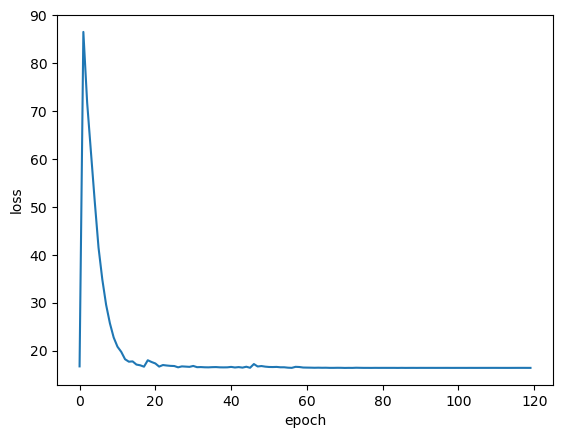

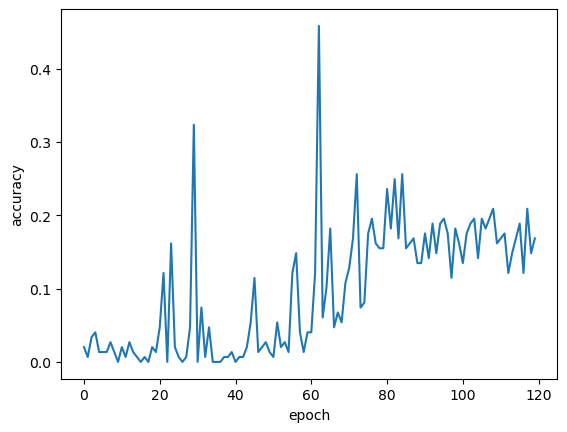

In [200]:
plt.plot([i for i in range(len(loss))],loss)
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([120,140])
plt.show()

plt.plot([i for i in range(len(accuracy))],accuracy)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()